In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r'C:\Users\nacho\OneDrive - University of Birmingham\DATA SCIENCE\Summer Project\all_player_data.csv'
df = pd.read_csv(file_path)


C:\Users\nacho\anaconda\envs\notebook-6.1.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



✅ Best combination:
n_neighbors=5, min_dist=0.0, k=6, silhouette=0.463


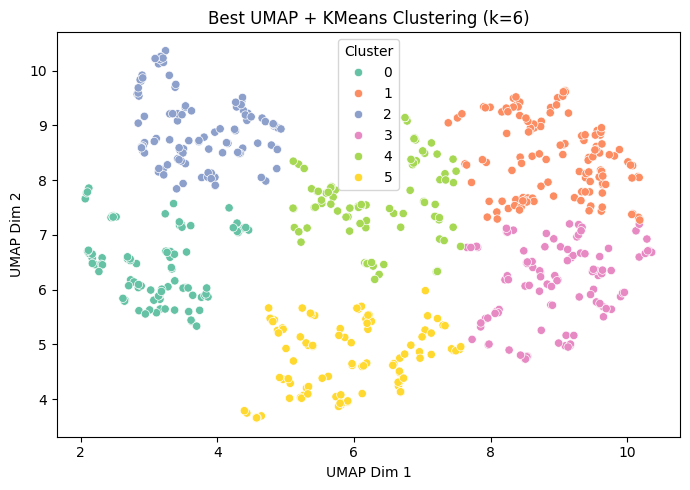

In [2]:
import warnings

warnings.filterwarnings("ignore")
df["projected_y"] = df["average_position_y"].apply(
    lambda y: 80 - y if y < 40 else y)

# Target position to analyze
target_position = 'midfielder'  # <- changed to CB

# Filter for the selected position
group = df[df["position"].str.lower() == target_position.lower()].copy()
usable_features = [
    # Passing
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    #'progressive_pass_accuracy', 
    'long_passes_per_90', 
    #'long_pass_accuracy', 
    'key_passes_per_90', 'crosses_per_90', #'cross_accuracy', #'assists_per_90', 
    'passes_received_per_90',
    
    #shots
    'shots_per_90', #'shots_on_target_per_90', 
    'shot_accuracy', #'goals_per_90', 
    #'first_time_shots_per_90', 
    'xg_per_90', #'headers_per_90', 
    'shots_outside_box_per_90',
    
    #dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 'dribbles_per_90', 'dribble_success_rate',
    #'successful_dribbles_per_90', 
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', #'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Aerials / Physicality
    'duels_per_90', 'duels_won_per_90', 'duel_success_rate',
    'fouls_made_per_90',

    # Positioning
    'touches_per_90', 'average_position_x', 'projected_y',
]
# Drop NAs and scale
X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
    exit()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP grid search parameters
n_neighbors_list = [ 5, 10, 15, 50]
min_dist_list = [0.0, 0.05, 0.1, 0.5, 0.7]

best_score = -1
best_params = None
best_embedding = None
best_k = None
best_labels = None

# Try all combinations
for n in n_neighbors_list:
    for d in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_scaled)

        for k in range(5, 14):  # try k=2 to k=5
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_umap)
            score = silhouette_score(X_umap, labels)


            
            if score > best_score:
                best_score = score
                best_params = (n, d)
                best_embedding = X_umap
                best_k = k
                best_labels = labels

# Report best
print("\n✅ Best combination:")
print(f"n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

# Plot best result
plt.figure(figsize=(7, 5))
sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
plt.title(f"Best UMAP + KMeans Clustering (k={best_k})")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [3]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')



=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0            30.170495      73.926930                   7.211321   
1            27.587914      79.787937                   7.919666   
2            21.402776      71.092807                   5.286469   
3            34.719523      80.418062                   9.903779   
4            30.401296      79.461711                   7.935453   
5            45.030991      80.423966                  12.856453   

         long_passes_per_90  key_passes_per_90  crosses_per_90  \
cluster                                                          
0                  3.481763           1.015215        1.433541   
1                  2.785665           0.332032        0.235698   
2                  2.260845           0.628306        0.924536   
3                  3.598683           0.398872        0.282922   
4                  2.9832

In [4]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, position {row['most_played_position']}")


Cluster 0:
Player: 9, Name: José Luis Morales Nogales, position Left Midfield
Player: 65, Name: Luis Alberto Romero Alconchel, position Center Attacking Midfield
Player: 82, Name: Juan Pablo Añor Acosta, position Right Midfield
Player: 89, Name: Gonzalo Castro Irizábal, position Left Midfield
Player: 112, Name: Marco Asensio Willemsen, position Center Attacking Midfield
Player: 118, Name: Pedro Taunausú Domínguez Placeres, position Center Attacking Midfield
Player: 143, Name: Samuel Castillejo Azuaga, position Left Midfield
Player: 148, Name: Denis Suárez Fernández, position Left Midfield
Player: 175, Name: Joaquín Sánchez Rodríguez, position Right Midfield
Player: 178, Name: Charly Musonda Junior, position Left Midfield
Player: 240, Name: Yannick Ferreira Carrasco, position Left Midfield
Player: 246, Name: André Filipe Tavares Gomes, position Left Center Midfield
Player: 268, Name: Ángel Martín Correa, position Right Midfield
Player: 276, Name: Víctor Rodríguez Romero, position Cente